# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Load data

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
fname = "7T1566"
nUS = 128
iS = 80

In [20]:
full_session_dir = "/home/projects/qrage/sessions/%s" % fname
h5_preproc_fname = "preproc/mz_me_mpnrage3d_grappa_pytorch.h5"
h5_image_fname = "images/mz_me_mpnrage3d_grappa_%s_%s.h5" % (iS, nUS)

In [21]:
full_h5_preproc_fname = os.path.join(full_session_dir, h5_preproc_fname)
full_h5_h5_image_fname = os.path.join(full_session_dir, h5_image_fname)

In [22]:
print(full_h5_preproc_fname)
print(full_h5_h5_image_fname)

/home/projects/qrage/sessions/7T1566/preproc/mz_me_mpnrage3d_grappa_pytorch.h5
/home/projects/qrage/sessions/7T1566/images/mz_me_mpnrage3d_grappa_80_128.h5


In [23]:
with h5py.File(
    full_h5_preproc_fname,
    "r",
    libver="latest",
    swmr=True,
) as h5_preproc_file:
    nC, nX, nY, nZ, nS = h5_preproc_file["C"].shape[:5]
    nC, spokes, baseresolution, nZ, nS, nTI, nTE = h5_preproc_file["d"].shape

    shape = (nX, nY, nZ, 1, nTI, nTE)

    print("Reconstructing slice %s of %s." % (iS, nS))

    nK = baseresolution * nUS

    # Read data
    C = h5_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
    k = h5_preproc_file["k"][:, :nUS, :, :, :, :, :]
    d = h5_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :, :] / 1e-4

    # nC = 1

    k = k.reshape((2, nK, 1, nTI, nTE))
    d = d.reshape((nC, nK, 1, nTI, nTE))

    C = torch.tensor(C, dtype=torch.complex64)
    k = torch.tensor(k, dtype=torch.float32)
    d = torch.tensor(d, dtype=torch.complex64)

Reconstructing slice 80 of 160.


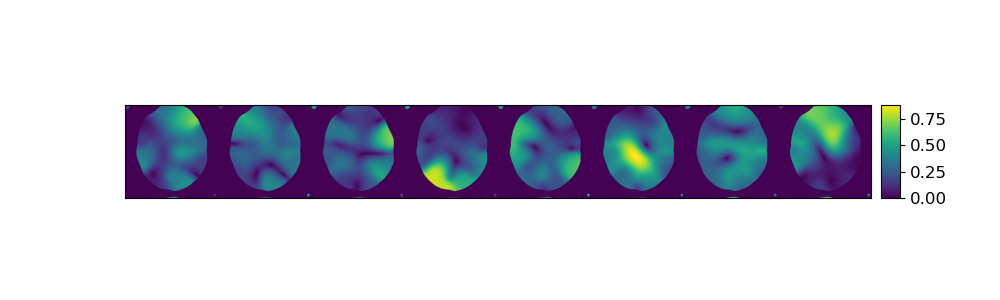

In [24]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, 8),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

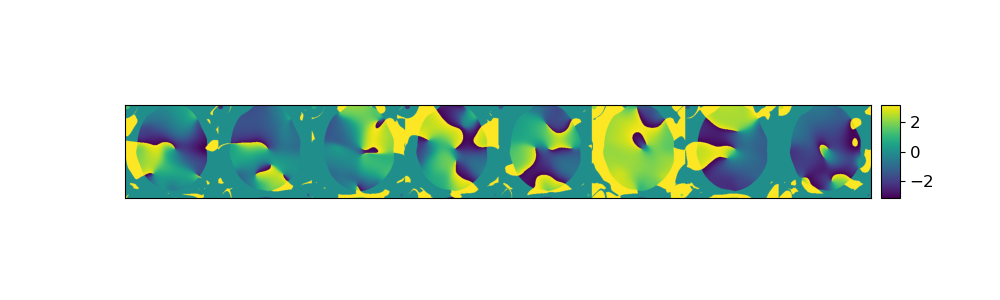

In [25]:
MultiPlotter(
    np.angle(C[..., 0, 0].numpy()),
    (1, 8),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [26]:
AHd = nonuniform_fourier_transform_adjoint(
    k,
    d,
    (nX, nY),
    modeord=0,
    isign=1,
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [27]:
H = nonuniform_transfer_function(k, (1, nX, nY, nZ, 1, nTI, nTE), oversampling=(2, 2))

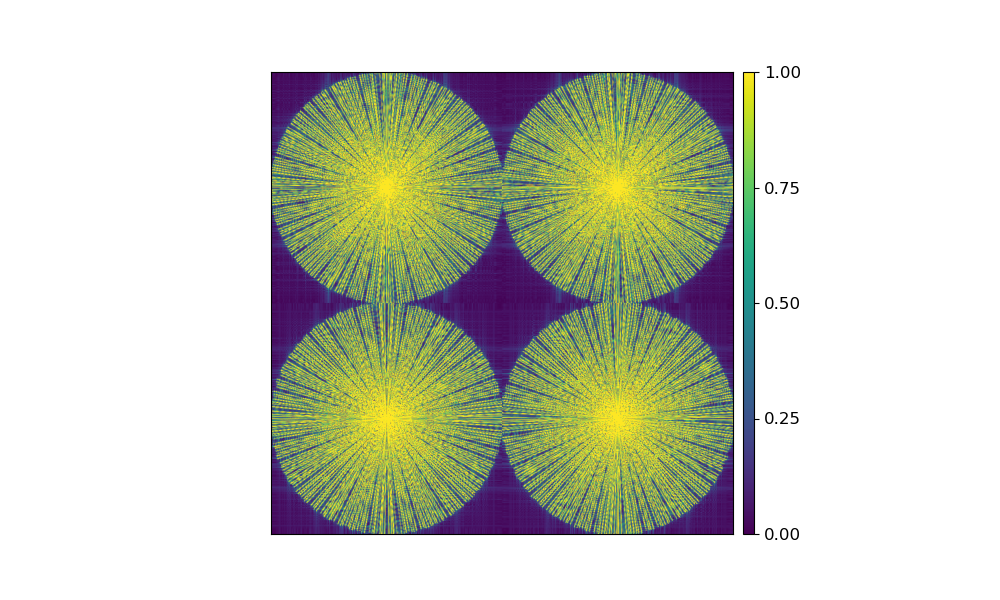

In [28]:
MultiPlotter(
    np.abs(H[0, :, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

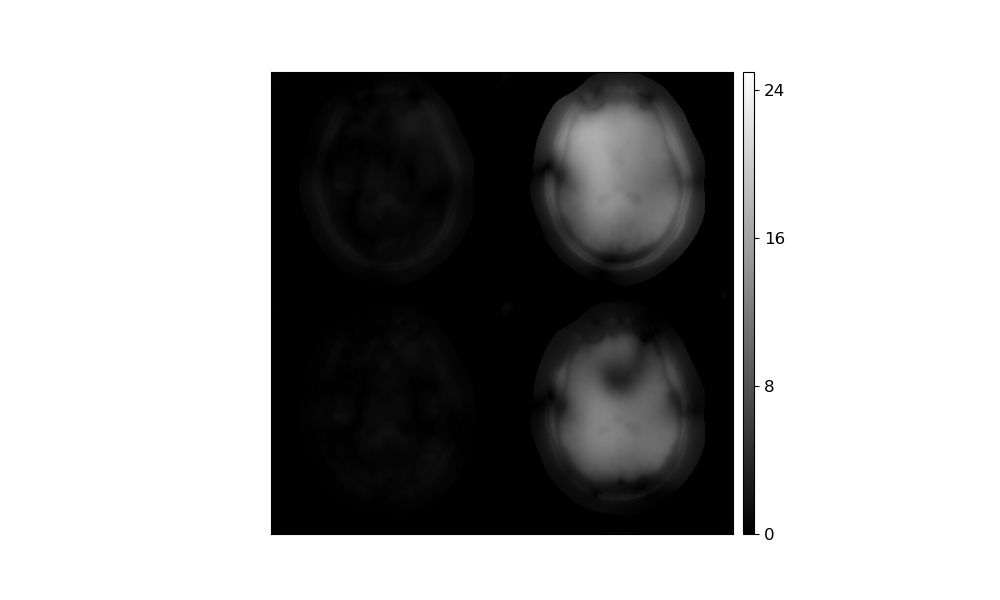

In [29]:
MultiPlotter(
    np.abs(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=0,
    vmax=25,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

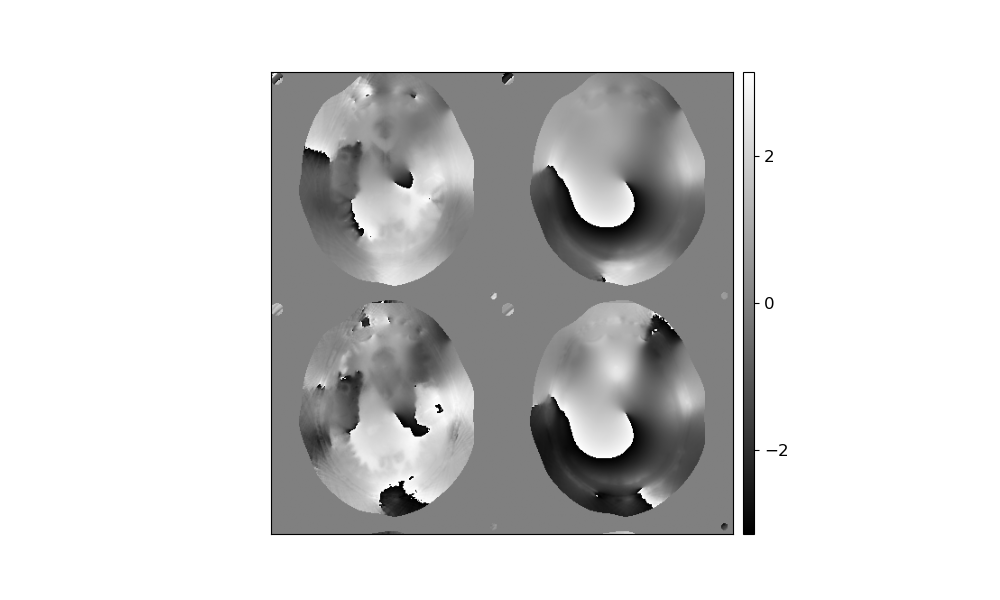

In [30]:
MultiPlotter(
    np.angle(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [31]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=1,
    weight_hankel=0.5,
    weight_casorati=0.5,
    cg_maxiter=5,
    admm_maxiter=30,
    callback=cm.callback,
)

[Convergence Monitor] Initialization complete.


In [32]:
# Run MIRAGE reconstruction
solver.solve()

[ADMM] Iter: 00 Prim Res: 9.86E+01 Dual Res: 9.86E+01 Rel Res: 1.00E+00:   3%|▎         | 1/30 [00:01<00:34,  1.18s/it]

[Convergence Monitor] Norm:  1.016e+00 	 Time per Iteration:  0.000e+00


[ADMM] Iter: 01 Prim Res: 9.01E+01 Dual Res: 1.77E+01 Rel Res: 9.75E-01:   7%|▋         | 2/30 [00:02<00:32,  1.16s/it]

[Convergence Monitor] Norm:  1.023e+00 	 Time per Iteration:  1.151e+00


[ADMM] Iter: 02 Prim Res: 1.20E+01 Dual Res: 9.18E+00 Rel Res: 9.54E-01:  10%|█         | 3/30 [00:03<00:31,  1.18s/it]

[Convergence Monitor] Norm:  1.025e+00 	 Time per Iteration:  1.204e+00


[ADMM] Iter: 03 Prim Res: 4.70E+00 Dual Res: 5.58E+00 Rel Res: 9.32E-01:  13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]

[Convergence Monitor] Norm:  1.027e+00 	 Time per Iteration:  1.110e+00


[ADMM] Iter: 04 Prim Res: 2.37E+00 Dual Res: 3.56E+00 Rel Res: 8.97E-01:  17%|█▋        | 5/30 [00:05<00:29,  1.16s/it]

[Convergence Monitor] Norm:  1.027e+00 	 Time per Iteration:  1.181e+00


[ADMM] Iter: 05 Prim Res: 1.32E+00 Dual Res: 2.38E+00 Rel Res: 8.50E-01:  20%|██        | 6/30 [00:07<00:28,  1.17s/it]

[Convergence Monitor] Norm:  1.028e+00 	 Time per Iteration:  1.178e+00


[ADMM] Iter: 06 Prim Res: 8.05E-01 Dual Res: 1.67E+00 Rel Res: 7.91E-01:  23%|██▎       | 7/30 [00:08<00:27,  1.18s/it]

[Convergence Monitor] Norm:  1.028e+00 	 Time per Iteration:  1.197e+00


[ADMM] Iter: 07 Prim Res: 5.10E-01 Dual Res: 1.21E+00 Rel Res: 7.22E-01:  27%|██▋       | 8/30 [00:09<00:25,  1.17s/it]

[Convergence Monitor] Norm:  1.028e+00 	 Time per Iteration:  1.149e+00


[ADMM] Iter: 08 Prim Res: 3.41E-01 Dual Res: 9.13E-01 Rel Res: 6.49E-01:  30%|███       | 9/30 [00:10<00:24,  1.16s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.143e+00


[ADMM] Iter: 09 Prim Res: 2.33E-01 Dual Res: 7.08E-01 Rel Res: 5.75E-01:  33%|███▎      | 10/30 [00:11<00:23,  1.18s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.222e+00


[ADMM] Iter: 10 Prim Res: 1.66E-01 Dual Res: 5.65E-01 Rel Res: 5.06E-01:  37%|███▋      | 11/30 [00:12<00:22,  1.18s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.183e+00


[ADMM] Iter: 11 Prim Res: 1.20E-01 Dual Res: 4.63E-01 Rel Res: 4.45E-01:  40%|████      | 12/30 [00:14<00:21,  1.17s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.158e+00


[ADMM] Iter: 12 Prim Res: 9.03E-02 Dual Res: 3.88E-01 Rel Res: 3.92E-01:  43%|████▎     | 13/30 [00:15<00:19,  1.16s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.137e+00


[ADMM] Iter: 13 Prim Res: 6.85E-02 Dual Res: 3.31E-01 Rel Res: 3.47E-01:  47%|████▋     | 14/30 [00:16<00:18,  1.16s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.149e+00


[ADMM] Iter: 14 Prim Res: 5.38E-02 Dual Res: 2.87E-01 Rel Res: 3.09E-01:  50%|█████     | 15/30 [00:17<00:17,  1.17s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.188e+00


[ADMM] Iter: 15 Prim Res: 4.26E-02 Dual Res: 2.52E-01 Rel Res: 2.77E-01:  53%|█████▎    | 16/30 [00:18<00:16,  1.19s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.240e+00


[ADMM] Iter: 16 Prim Res: 3.49E-02 Dual Res: 2.24E-01 Rel Res: 2.51E-01:  57%|█████▋    | 17/30 [00:19<00:15,  1.17s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.138e+00


[ADMM] Iter: 17 Prim Res: 2.88E-02 Dual Res: 2.01E-01 Rel Res: 2.28E-01:  60%|██████    | 18/30 [00:21<00:13,  1.16s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.143e+00


[ADMM] Iter: 18 Prim Res: 2.45E-02 Dual Res: 1.83E-01 Rel Res: 2.08E-01:  63%|██████▎   | 19/30 [00:22<00:12,  1.17s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.181e+00


[ADMM] Iter: 19 Prim Res: 2.09E-02 Dual Res: 1.67E-01 Rel Res: 1.91E-01:  67%|██████▋   | 20/30 [00:23<00:11,  1.12s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.019e+00


[ADMM] Iter: 20 Prim Res: 1.83E-02 Dual Res: 1.53E-01 Rel Res: 1.77E-01:  70%|███████   | 21/30 [00:24<00:10,  1.14s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.162e+00


[ADMM] Iter: 21 Prim Res: 1.60E-02 Dual Res: 1.42E-01 Rel Res: 1.64E-01:  73%|███████▎  | 22/30 [00:25<00:09,  1.15s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.190e+00


[ADMM] Iter: 22 Prim Res: 1.44E-02 Dual Res: 1.32E-01 Rel Res: 1.53E-01:  77%|███████▋  | 23/30 [00:26<00:08,  1.15s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.149e+00


[ADMM] Iter: 23 Prim Res: 1.29E-02 Dual Res: 1.23E-01 Rel Res: 1.43E-01:  80%|████████  | 24/30 [00:27<00:06,  1.15s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.153e+00


[ADMM] Iter: 24 Prim Res: 1.18E-02 Dual Res: 1.15E-01 Rel Res: 1.35E-01:  83%|████████▎ | 25/30 [00:29<00:05,  1.17s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.201e+00


[ADMM] Iter: 25 Prim Res: 1.07E-02 Dual Res: 1.08E-01 Rel Res: 1.27E-01:  87%|████████▋ | 26/30 [00:30<00:04,  1.15s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.131e+00


[ADMM] Iter: 26 Prim Res: 9.96E-03 Dual Res: 1.02E-01 Rel Res: 1.20E-01:  90%|█████████ | 27/30 [00:31<00:03,  1.15s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.145e+00


[ADMM] Iter: 27 Prim Res: 9.21E-03 Dual Res: 9.70E-02 Rel Res: 1.14E-01:  93%|█████████▎| 28/30 [00:32<00:02,  1.17s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.204e+00


[ADMM] Iter: 28 Prim Res: 8.66E-03 Dual Res: 9.21E-02 Rel Res: 1.08E-01:  97%|█████████▋| 29/30 [00:33<00:01,  1.16s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.154e+00


[ADMM] Iter: 29 Prim Res: 8.08E-03 Dual Res: 8.77E-02 Rel Res: 1.03E-01: 100%|██████████| 30/30 [00:34<00:00,  1.16s/it]

[Convergence Monitor] Norm:  1.029e+00 	 Time per Iteration:  1.148e+00


tensor([ 0.0022, -0.0198, -0.0011,  ..., -0.0141,  0.0009, -0.0002])

In [33]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

/tmp/ipykernel_83177/2941436105.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(z_image[..., 0, 0, :, :]),


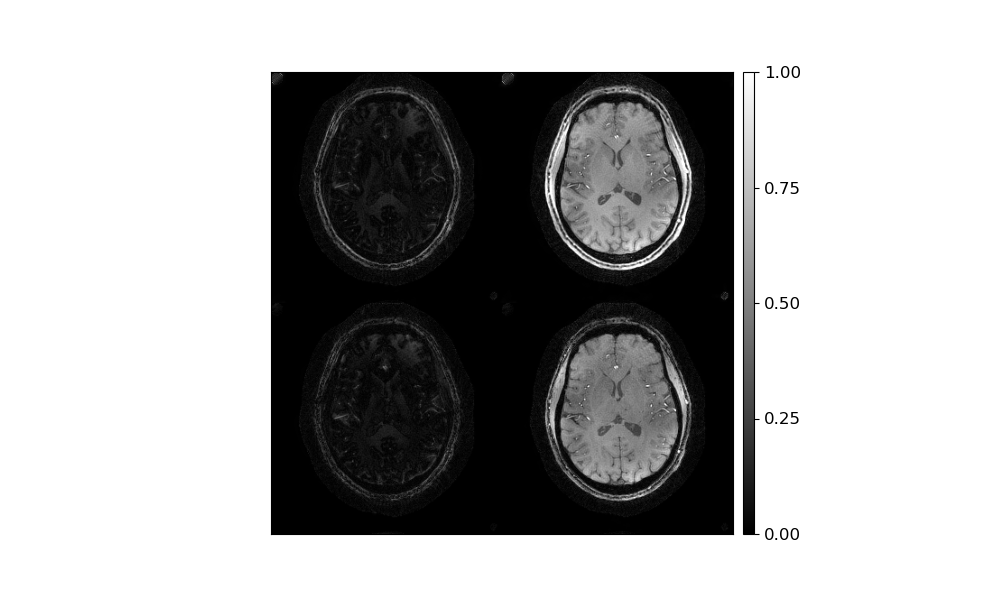

In [34]:
MultiPlotter(
    np.abs(z_image[..., 0, 0, :, :]),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)